# 🧠🤖 Treinando uma CNN com Pytorch

1. https://learnopencv.com/understanding-convolutional-neural-networks-cnn/
1. https://medium.com/codex/understanding-convolutional-neural-networks-a-beginners-journey-into-the-architecture-aab30dface10
2. https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
3. https://www.youtube.com/watch?v=KuXjwB4LzSA
4. https://www.youtube.com/watch?app=desktop&v=JboZfxUjLSk
5. https://www.kaggle.com/code/amarjeet007/visualize-cnn-with-keras


Neste notebook, vamos treinar uma rede neural convolucional usando a base de dados MNIST. Seguiremos os seguintes passos em ordem:

1. Carregar e normalizar os conjuntos de dados de treinamento e teste usando `torchvision`
2. Definir uma Rede Neural Convolucional
3. Definir uma função de perda
4. Treinar a rede com os dados de treinamento
5. Testar a rede com os dados de teste

**Obs.**: O pacote `torchvision` possui várias classes úteis para operação com imagens. 


## Exemplo Simples de Convolução com Imagens

In [38]:
import cv2
import numpy as np

def convolve(img, kernel):
    # cria a imagem de saida
    out = np.zeros_like(img)

    # Cria uma copia da entrada com padding.
    # Assume kernel de tamanho impar e quadrado
    pad_sz = (kernel.shape[0] // 2)
    padded = np.zeros((img.shape[0] + 2 * pad_sz, img.shape[1] + 2 * pad_sz))
    padded[pad_sz: img.shape[0] + pad_sz, pad_sz: img.shape[1] + pad_sz] = img

    # itera sobre os pixels da imagem
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            # seleciona a subimagem
            subimg = padded[i:i + kernel.shape[0], j:j + kernel.shape[1]]

            # multiplica o kernel pela subimagem elemento a elemento
            # e soma os valores
            out[i, j] = np.sum(kernel * subimg)

    return out



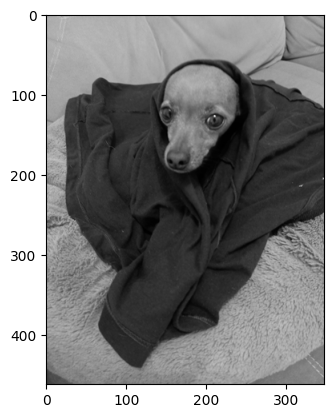

In [2]:
import matplotlib.pyplot as plt

img = cv2.cvtColor(cv2.imread("magui.png"), cv2.COLOR_BGR2GRAY)
img = img.astype(float) / 255
plt.imshow(img, cmap='gray')

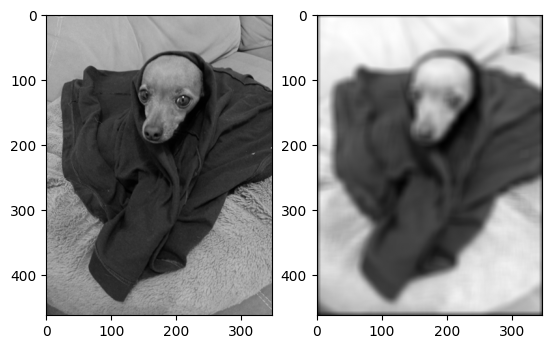

In [3]:
kernel = np.ones((13, 13))
kernel /= kernel.size

out = convolve(img, kernel)
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')

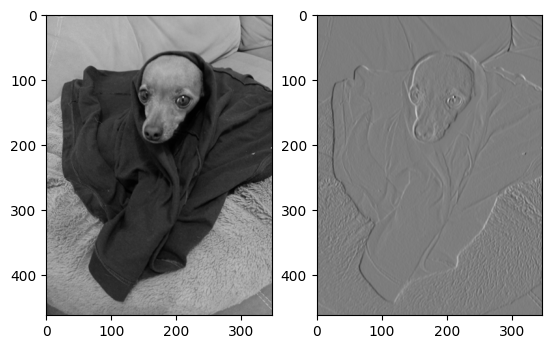

In [4]:
kernel = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1],
])

out = convolve(img, kernel)
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')

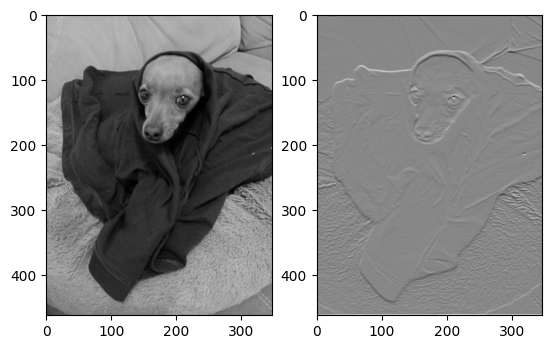

In [5]:
kernel = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1],
])

out = convolve(img, kernel)
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')

## Treinamento de uma CNN com Pytorch


### Carrega e normaliza os dados


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     # normaliza para [-1, 1] subtraindo 0.5 e depois dividindo poir 0.5
     transforms.Normalize((0.5), (0.5))])

batch_size = 64

trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = [str(i) for i in range(10)]

Mostra algumas imagens de treinamento

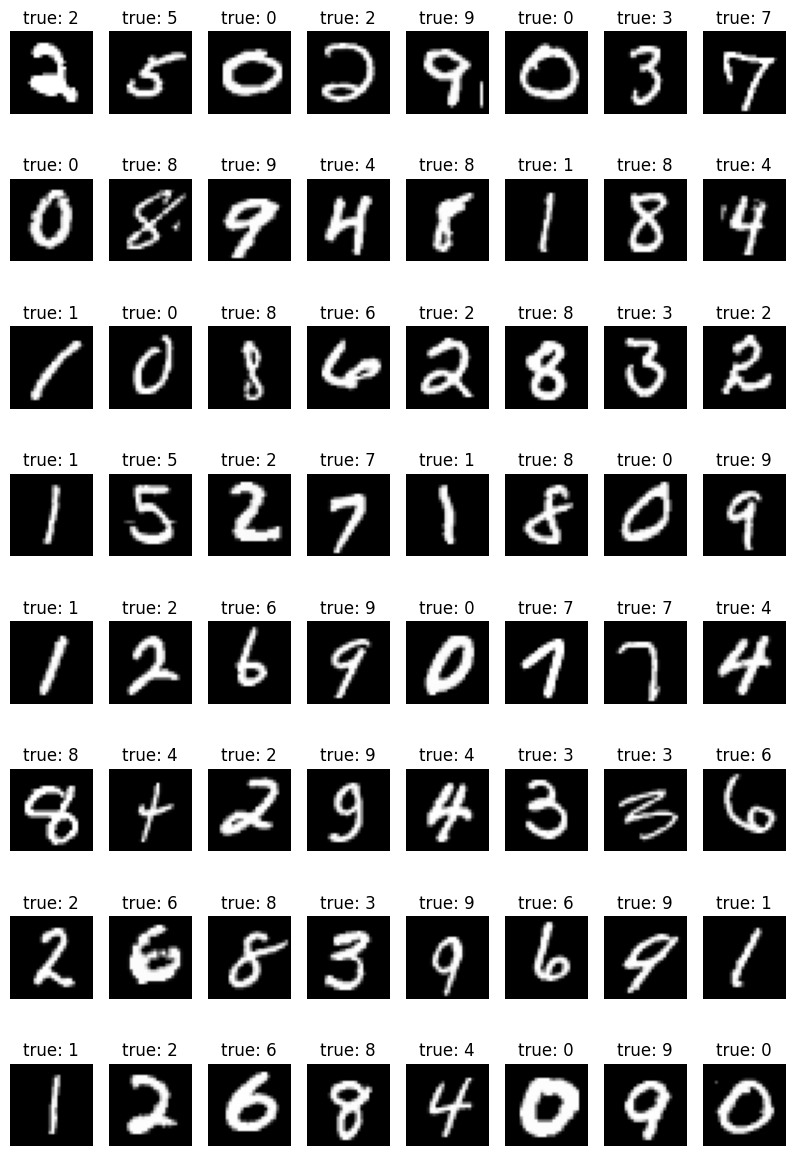

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(images, labels, net=None):
    prd = None
    if net:
        with torch.no_grad():
            prd = net(images).numpy()
        # classe mais provavel por amostra
        prd = np.argmax(prd, axis=-1)

    n = len(images)
    grid_size = int(np.ceil(np.sqrt(n)))

    for idx in range(n):
        plt.subplot(grid_size, grid_size, idx + 1)
        img = images[idx].numpy()

        # muda do formato [channels, rows, cols] do torch para [rows, cols, channels]
        img = np.transpose(img, (1, 2, 0))

        plt.imshow(img, cmap='gray')
        plt.grid(False)
        plt.axis('off')
        title = f'true: {labels[idx].numpy()}'
        if prd is not None:
            title += f'\nprd: {prd[idx]}'
        plt.title(title)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

plt.close('all')
plt.figure(figsize=(10, 15))
show_batch(images, labels)
plt.show()


### 2. Define a CNN



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # para saber o tamanho da entrada abaixo, faça um print do x no forward antes do flatten
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

    def embedding(self, x):
        # para na penultima camada
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Forma alternativa de definir a CNN usando nn.Sequential:

In [ ]:

# IMPORTANTE: poderíamos definir a rede em um nn.Sequential apenas.
# A divisão em duas partes teve como objetivo permitir a extração de embeddings depois.

# feature extractor
conv = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),   # lembre-se do flatten!
    nn.Linear(16 * 4 * 4, 120),
    nn.ReLU(),
    nn.Linear(120, 84)
)

# rede completa: feature extractor + classifier
net = nn.Sequential(
    conv,
    nn.ReLU(),
    nn.Linear(84, 10)
)

net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
  )
  (1): ReLU()
  (2): Linear(in_features=84, out_features=10, bias=True)
)

### Mostra como os dados são distribuídos no espaço antes do treinamento

*Pode demorar alguns segundos para rodar*

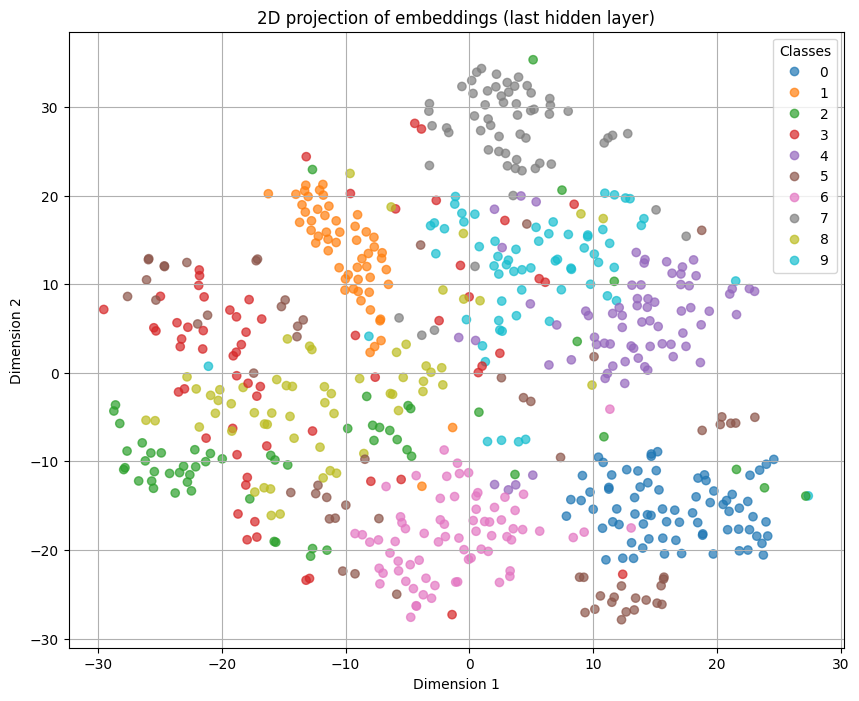

In [8]:
from sklearn.manifold import TSNE
from itertools import islice

###################################
# IMPORTANTE: descomente uma das linhas abaixo dependendo de como a rede foi criada
###################################
# Caso criada com a classe
embedding_model = net.embedding
# Caso criada com nn.Sequential
# embedding_model = conv

def plot_embeddings(dataloader, n_batches=10):
    # Collect embeddings, images, and labels
    all_embeddings = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for inputs, labels in islice(dataloader, n_batches):   # only the first 10 batches
            outputs = embedding_model(inputs)
            all_embeddings.append(outputs)
            all_labels.append(labels)
            all_images.append(inputs)  # store input images

    # Flatten everything
    embeddings = torch.cat(all_embeddings).numpy()
    labels = torch.cat(all_labels).numpy()
    images = torch.cat(all_images)  # shape: [N, 1, H, W]

    # Reduce to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("2D projection of embeddings (last hidden layer)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)

plt.figure(figsize=(10, 8))
plot_embeddings(trainloader, n_batches=10)
plt.show()

### Define a Loss function e o optimizer


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

### Treina a Rede


*Pode demorar alguns segundos para rodar*

In [20]:

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss:.3f}')
    running_loss = 0.0

print('Finished Training')

[1] loss: 36.003
[2] loss: 31.378
[3] loss: 26.052
[4] loss: 22.781
[5] loss: 19.293
Finished Training


A próxima célula salva o modelo.
Clique [aqui](https://pytorch.org/docs/stable/notes/serialization.html) para saber mais sobre como salvar e carregar PyTorch models.

In [ ]:
PATH = './cnn-mnist.pth'
torch.save(net, PATH)



### Test the network on the test data



Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [ ]:
net = torch.load(PATH, weights_only=False)

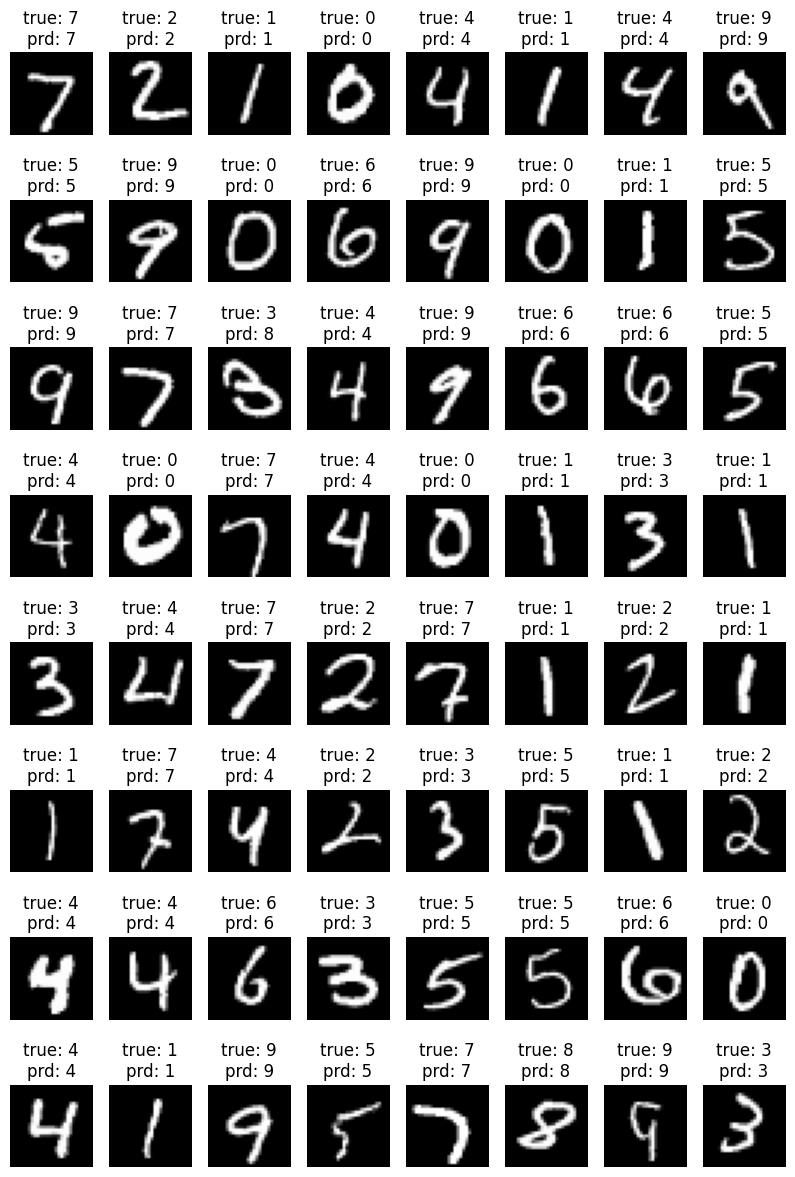

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

plt.close('all')
plt.figure(figsize=(10, 15))
show_batch(images, labels, net)
plt.show()

Resultados no conjunto de teste:

In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')

Accuracy of the network on test images: 98 %


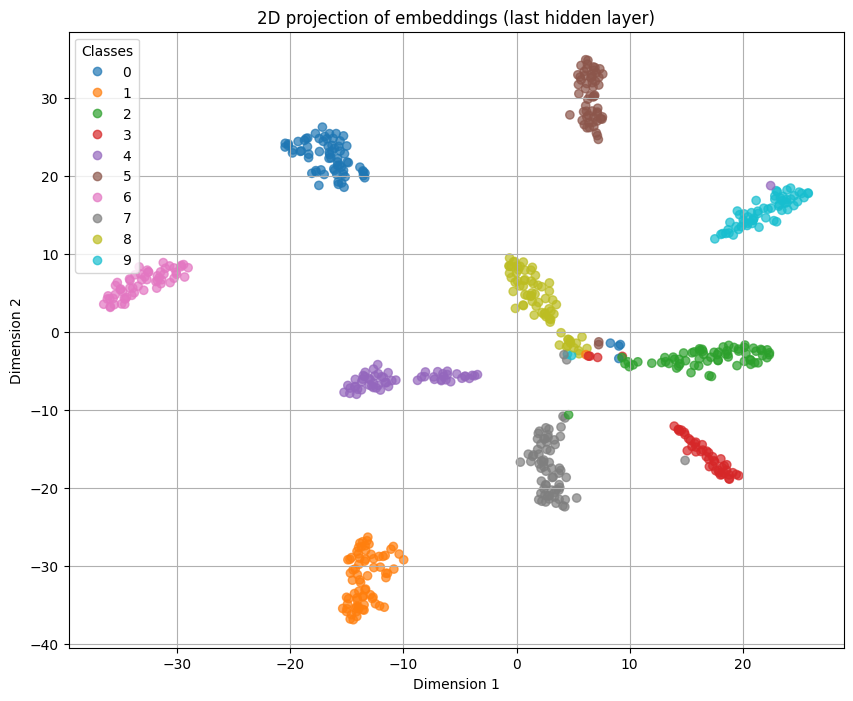

In [ ]:
plt.figure(figsize=(10, 8))
plot_embeddings(trainloader, n_batches=10)
plt.show()

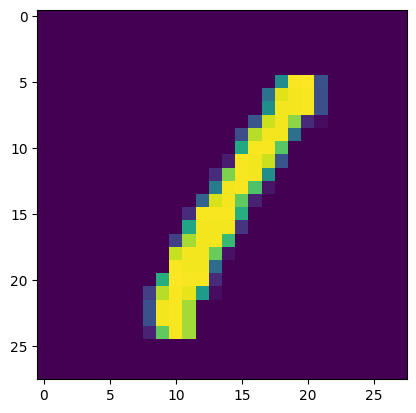

In [48]:
img = trainset[3][0].permute(1, 2, 0).squeeze()
plt.imshow(img)

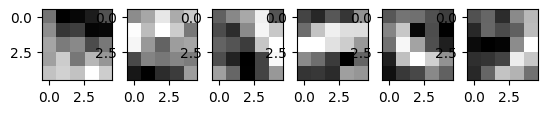

In [ ]:
weights = net.conv1.weight.data.numpy()

for idx in range(len(weights)):
    kernel = weights[idx].squeeze()
    plt.subplot(1, len(weights), idx + 1)
    plt.imshow(kernel, cmap='gray')


C:\Users\Windows\AppData\Local\Temp\ipykernel_45820\3007556221.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  padded[pad_sz: img.shape[0] + pad_sz, pad_sz: img.shape[1] + pad_sz] = img


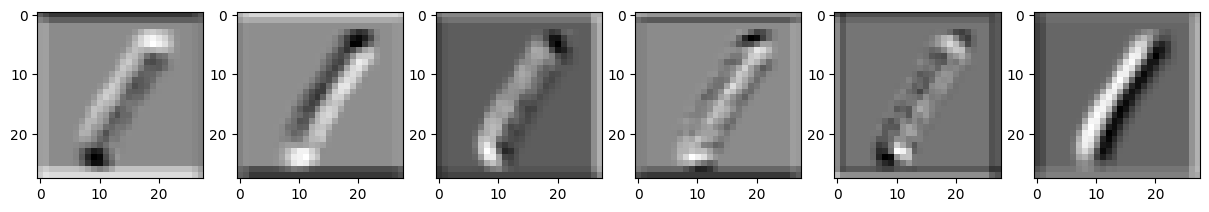

In [ ]:

weights = net.conv1.weight.data.numpy()

plt.figure(figsize=(15, 5))
for idx in range(len(weights)):
    kernel = weights[idx].squeeze()
    result = convolve(img, kernel)
    plt.subplot(1, len(weights), idx + 1)
    plt.imshow(result, cmap='gray')
